In [4]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [8]:
import torch
from torchvision import models

# 1. Define the model architecture
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 output classes

# 2. Load your state_dict
model.load_state_dict(torch.load("brain_tumor_model.pth", map_location=torch.device('cpu')))
model.eval()


# 2. Class labels
class_names = ['Glioma','Meningioma','No Tumor', 'Pituitary']


# 3. Preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # change if your model uses a different size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet values
                         std=[0.229, 0.224, 0.225])
])

/home/tanuj/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tanuj/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

# def preprocess_image(image_path):
#     image = Image.open(image_path).convert("RGB")
#     return transform(image).unsqueeze(0), image

# # 4. Function to predict for LIME
# def batch_predict(images):
#     model.eval()
#     batch = torch.stack([transform(Image.fromarray(img).convert("RGB")) for img in images], dim=0)
#     with torch.no_grad():
#         logits = model(batch)
#         probs = F.softmax(logits, dim=1)
#     return probs.detach().cpu().numpy()

# # 5. Explain with LIME
# def explain_with_lime(image_path):
#     tensor_image, pil_image = preprocess_image(image_path)
#     image_np = np.array(pil_image)

#     explainer = lime_image.LimeImageExplainer()
#     explanation = explainer.explain_instance(
#         image_np,
#         batch_predict,
#         top_labels=1,
#         hide_color=0,
#         num_samples=1000
#     )

#     # Get explanation for the predicted class
#     pred_probs = batch_predict([image_np])[0]
#     predicted_class = np.argmax(pred_probs)

#     temp, mask = explanation.get_image_and_mask(
#         label=predicted_class,
#         positive_only=True,
#         num_features=5,
#         hide_rest=False
#     )

#     # Show result
#     print(f"Predicted: {class_names[predicted_class]} (Confidence: {pred_probs[predicted_class]:.2f})")
#     plt.figure(figsize=(6,6))
#     plt.title(f"Prediction: {class_names[predicted_class]}")
#     plt.imshow(mark_boundaries(temp, mask))
#     plt.axis('off')
#     plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted: Meningioma (Confidence: 1.00)


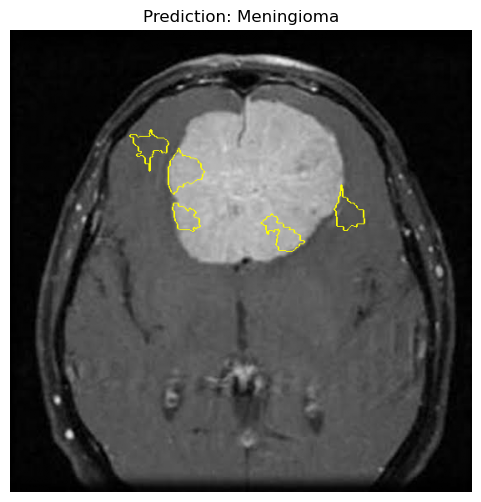

In [ ]:

# # 6. Run
# explain_with_lime("/home/tanuj/Brain_MRI/brain_tumor_mri_dataset/Testing/meningioma/image(2).jpg")  # Replace with your MRI image path


In [ ]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import os

# 1. Load ResNet50 model
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # 4 classes
model.load_state_dict(torch.load("brain_tumor_model.pt", map_location=torch.device('cpu')))
model.eval()

# 2. Class labels
class_names = ['Meningioma', 'Glioma', 'Pituitary', 'No Tumor']

# 3. Image preprocessing (ImageNet-style)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# 4. Load and preprocess the MRI image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dim
    return image, image_tensor

# 5. SHAP uses background data – select 5 random background images
def get_background_images(folder, num=5):
    images = []
    for fname in os.listdir(folder)[:num]:
        path = os.path.join(folder, fname)
        img = Image.open(path).convert('RGB')
        images.append(transform(img))
    return torch.stack(images)

# 6. Run SHAP explanation
def explain_with_shap(image_path, background_folder):
    pil_img, input_tensor = load_image(image_path)

    # Get background data
    background = get_background_images(background_folder)

    # Use GradientExplainer for PyTorch models
    explainer = shap.GradientExplainer(model, background)
    shap_values, indexes = explainer.shap_values(input_tensor)

    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional
